In [22]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
from astroquery.vizier import Vizier
import subprocess
import os

In [23]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0
    
dependencies = [('source-extractor', 'sex'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.") 

source-extractor is installed properly as sex. OK
psfex is installed properly as psfex. OK
2 out of 2 external dependencies installed properly.

You are ready to continue.


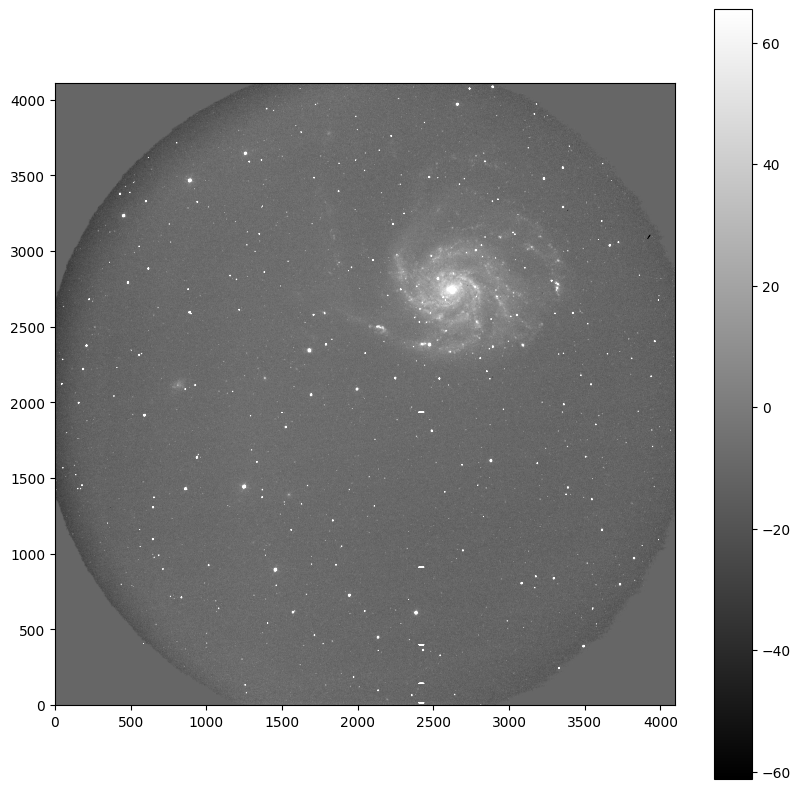

In [24]:
os.chdir('/Users/jigyasachouhan/Documents/Krittika/KSP/Task 2/files_TASK_2')
imageName = '20230521154933-241-RA.wcs.proc.fits'

with fits.open(imageName) as HDUList:
    header = HDUList[0].header
    image = HDUList[0].data

zscale = ZScaleInterval().get_limits(image)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray', origin='lower', vmin=zscale[0], vmax=zscale[1])
plt.colorbar()
plt.show()

In [25]:
w = WCS(header)
(raImage, decImage) = w.all_pix2world(image.shape[0]/2, image.shape[1]/2, 1)
boxsize = 30 # arcminutes
maxmag = 18

catNum = 'II/349'
print(f'\nQuerying Vizier {catNum} around RA {raImage:.4f}, Dec {decImage:.4f} with a radius of {boxsize} arcmin')

try:
    # You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
    v = Vizier(columns=['*'], column_filters={"gmag":f"<{maxmag}", "Nd":">6", "e_gmag":f"<{1.086/3}"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra=raImage, dec=decImage, unit=(u.deg, u.deg)), radius=str(boxsize)+'m', catalog=catNum, cache=False)
    print(Q[0])
except:
    print('I cannnot reach the Vizier database. Is the internet working?')


Querying Vizier II/349 around RA 211.0825, Dec 54.3099 with a radius of 30 arcmin
   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag yFlags
     deg           deg                         ...   mag     mag         
------------- ------------- ------------------ ... ------- ------- ------
210.729459870  53.862978240 172632107294506278 ... 15.1832  0.0043 115000
210.663724090  53.919290610 172702106637313866 ... 16.4559  0.0164 115000
210.663539540  53.892741500 172672106635471999 ... 16.3082  0.0166 115000
210.604486980  53.926405740 172712106044792397 ... 16.4376  0.0142 115000
210.625757450  53.949266840 172732106257949830 ... 13.8435  0.0035 115000
210.517574290  53.936533960 172722105175484556 ... 17.1413  0.0198 115000
210.559704780  53.937696580 172722105596905934 ... 15.5672  0.0071 115000
210.439170920  54.003287860 172802104391914650 ... 14.9887  0.0043 115000
210.447712130  54.046944570 172852104477077040 ... 14.0260  0.0031 115000
          ...           ...  

In [26]:
Q[0].meta['desc'] = Q[0].meta.pop('description')
Q[0].write('/Users/jigyasachouhan/Documents/Krittika/KSP/Task 2/files_TASK_2/ps1Catalog.fits', format='fits', overwrite=True)

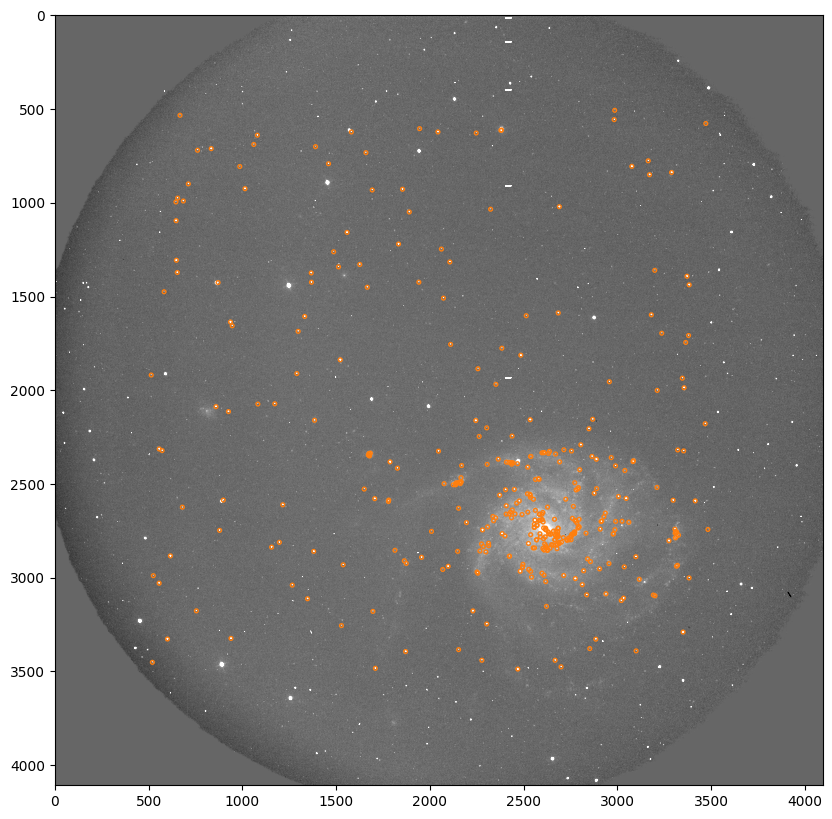

In [27]:
ps1_imCoords = w.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)
good_cat_stars = Q[0][np.where((ps1_imCoords[0] > 500) & (ps1_imCoords[0] < 3500) & (ps1_imCoords[1] > 500) & (ps1_imCoords[1] < 3500))]
ps1_imCoords = w.all_world2pix(good_cat_stars['RAJ2000'],good_cat_stars['DEJ2000'], 1)

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((ps1_imCoords[0][i], ps1_imCoords[1][i]), radius = 10, edgecolor='C1', facecolor='None') for i in range(len(ps1_imCoords[0]))]
for c in circles:
    ax.add_artist(c)
    
plt.show()

In [28]:
configFile = 'photomCat.sex'
catalogName = imageName + '.cat'
paramName = 'photomCat.param'
try:
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {catalogName} -PARAMETERS_NAME {paramName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230521154933-241-RA.wcs.proc.fits -CATALOG_NAME 20230521154933-241-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2024-07-01 at 12:03:23 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521154933-241-RA.wcs.proc.fits
----- Measuring from: 20230521154933-241-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -10.0883   RMS: 12.9684    / Threshold: 129.684    
> Scanning image
> Line:   25  Objects:        2 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        4 detected /        0 sextracted
> Line:  100

In [29]:
with fits.open(catalogName) as HDU:
    print(HDU.info())
    sourceTable = Table(HDU[2].data)

print(sourceTable.colnames)
print(sourceTable)

cleanSources = sourceTable[(sourceTable['FLAGS']==0) & (sourceTable['FWHM_WORLD'] < 2) & (sourceTable['XWIN_IMAGE']<3500) & (sourceTable['XWIN_IMAGE']>500) & (sourceTable['YWIN_IMAGE']<3500) & (sourceTable['YWIN_IMAGE']>500)]

Filename: 20230521154933-241-RA.wcs.proc.fits.cat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [19040A]   
  2  LDAC_OBJECTS    1 BinTableHDU    106   397R x 25C   [729E, 1E, 1E, 1D, 1D, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1E, 1E, 10E, 10E, 10E, 10E]   
None
['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
          VIGNET           X_IMAGE  ...          MAGERR_APER          
------------------------- --------- ... ------------------------------
   -15.076683 .. 31.05746 2417.4841 ... 0.00036070598 .. 0.00036346662
      -1e+30 .. -10.26661 2809.0112 ...  

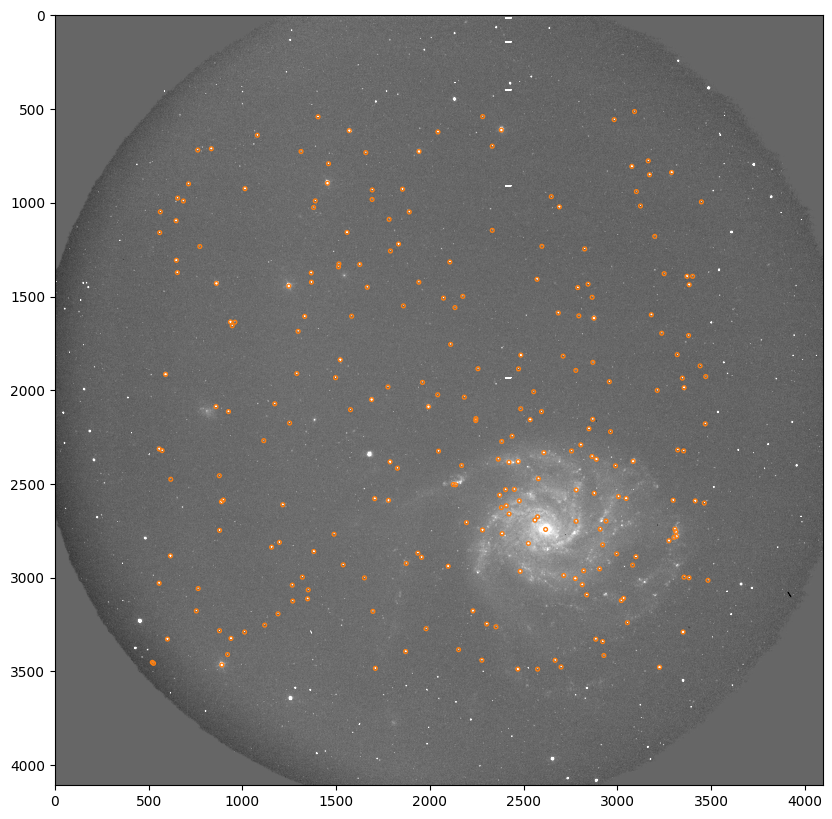

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((source['XWIN_IMAGE'], source['YWIN_IMAGE']), radius = 10, edgecolor='C1', facecolor='None') for source in cleanSources]
for c in circles:
    ax.add_artist(c)
plt.show()

In [31]:
psfConfigFile = 'psfex_conf.psfex'

try:
    command = f'psfex -c {psfConfigFile} {catalogName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run psfex with exit error {err}')

Executing command: psfex -c psfex_conf.psfex 20230521154933-241-RA.wcs.proc.fits.cat



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



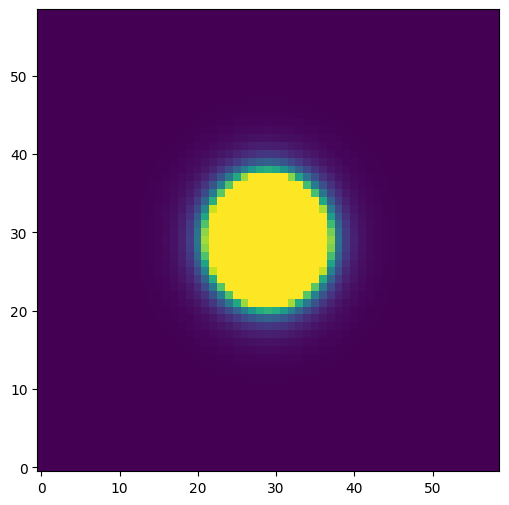

In [32]:
psfModelHDU = fits.open('moffat_' + imageName + '.fits')[0]
psfModelData = psfModelHDU.data
mean, median, std = sigma_clipped_stats(psfModelData)

plt.figure(figsize=(6,6))
plt.imshow(psfModelData, vmin=0, vmax=median+20*std, origin='lower')
plt.show()

In [33]:
psfName = imageName + '.psf'
psfcatalogName = imageName+'.psf.cat'
psfparamName = 'photomPSF.param' # This is a new set of parameters to be obtained from SExtractor, including PSF-fit magnitudes
try:
    # We are supplying SExtactor with the PSF model with the PSF_NAME option
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {psfcatalogName} -PSF_NAME {psfName} -PARAMETERS_NAME {psfparamName}'
    print(f"Executing command: {command}")
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230521154933-241-RA.wcs.proc.fits -CATALOG_NAME 20230521154933-241-RA.wcs.proc.fits.psf.cat -PSF_NAME 20230521154933-241-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2024-07-01 at 12:03:26 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521154933-241-RA.wcs.proc.fits
----- Measuring from: 20230521154933-241-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -10.0883   RMS: 12.9684    / Threshold: 129.684    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextr

In [34]:
with fits.open(psfcatalogName) as HDU:
    psfsourceTable = Table(HDU[2].data)

print(psfsourceTable.colnames)
print(psfsourceTable)

cleanPSFSources = psfsourceTable[(psfsourceTable['FLAGS']==0) & (psfsourceTable['FLAGS_MODEL']==0)  & (psfsourceTable['FWHM_WORLD'] < 2) & (psfsourceTable['XMODEL_IMAGE']<3500) & (psfsourceTable['XMODEL_IMAGE']>500) &(psfsourceTable['YMODEL_IMAGE']<3500) &(psfsourceTable['YMODEL_IMAGE']>500)]

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLAGS_MODEL', 'NITER_MODEL', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_POINTSOURCE', 'FLUXERR_POINTSOURCE', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'FLUXRATIO_POINTSOURCE', 'FLUXRATIOERR_POINTSOURCE']
          VIGNET           X_IMAGE  ... FLUXRATIOERR_POINTSOURCE
------------------------- --------- ... ------------------------
   -15.076683 .. 31.05746 2417.4841 ...                      0.0
      -1e+30 .. -10.26661 2809.0112 ...                      0.0
    9.765148 .. 20.164497 2353.6553 ...                      0.0
   1.8691392 .. 7.1863313  2636.815 ...                      0.0
  27.083986 .. -1.9768791 1262.5209 ...                      0.0
      -9.653 .. 7.9423313  2131.598 ...                 

In [35]:
psfsourceCatCoords = SkyCoord(ra=cleanPSFSources['ALPHAWIN_J2000'], dec=cleanPSFSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
ps1CatCoords = SkyCoord(ra=good_cat_stars['RAJ2000'], dec=good_cat_stars['DEJ2000'], frame='icrs', unit='degree')
photoDistThresh = 0.6
idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(psfsourceCatCoords, photoDistThresh*u.arcsec)

print(f'Found {len(idx_psfimage)} good cross-matches')

Found 137 good cross-matches


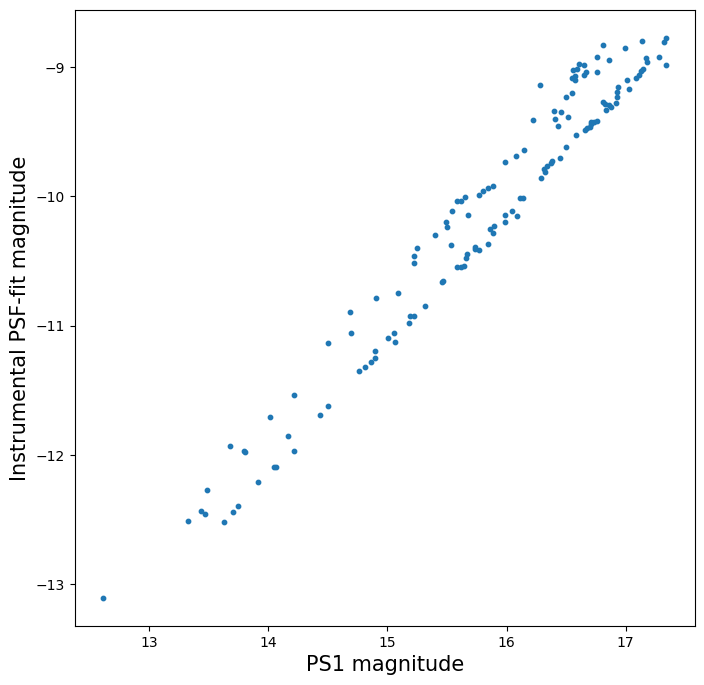

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(good_cat_stars['gmag'][idx_psfps1], cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage], color='C0', s=10)
plt.xlabel('PS1 magnitude', fontsize=15)
plt.ylabel('Instrumental PSF-fit magnitude', fontsize=15)
plt.show()

In [37]:
psfoffsets = ma.array(good_cat_stars['gmag'][idx_psfps1] - cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage])
zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
print('PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f'%(zero_psfmean, zero_psfmed, zero_psfstd))

PSF Mean ZP: 25.97
PSF Median ZP: 26.11
PSF STD ZP: 0.21


In [38]:
ra = 210.910674637
dec = 54.3116510708

sn2023ixf_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idx_sn2023ixf, idx_cleanpsf_sn2023ixf, d2d, d3d = psfsourceCatCoords.search_around_sky(sn2023ixf_coords, photoDistThresh*u.arcsec)
print(f'Found the source at index {idx_cleanpsf_sn2023ixf[0]}')

Found the source at index 132


In [39]:
sn2023ixf_psfinstmag = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAG_POINTSOURCE'][0]
sn2023ixf_psfinstmagerr = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAGERR_POINTSOURCE'][0]

sn2023ixf_psfmag = zero_psfmed + sn2023ixf_psfinstmag
sn2023ixf_psfmagerr = np.sqrt(sn2023ixf_psfinstmagerr**2 + zero_psfstd**2)

print(f'PSF-fit magnitude of SN2023ixf is {sn2023ixf_psfmag} +/- {sn2023ixf_psfmagerr}')

PSF-fit magnitude of SN2023ixf is 11.419347243499757 +/- 0.21268209805450042
